In [1]:
import os
import time
import datetime
import numpy as np
import warnings
import random
from PIL import Image
from tqdm import tqdm

from labels import labels

In [2]:
# 데이터 경로
#  os.getcwd() :'/home/ag/Capstone2/DeepLab_V3_ver1'
origin_data_path = os.getcwd() + '/data/Original_data/'
labeled_data_path = os.getcwd() + '/data/Labeled_data/'

origin_data_list = os.listdir(origin_data_path) # x
labeled_data_list = os.listdir(labeled_data_path) # y

# 파일명 랜덤
random.shuffle(origin_data_list)
random.shuffle(labeled_data_list)

# train, test / x, y 
train_x_file = origin_data_list[:int(len(origin_data_list)*0.8)]
train_y_file = [file_name[:-4] + '_L.png' for file_name in train_x_file]

test_x_file = [file_name for file_name in origin_data_list if file_name not in train_x_file]
test_y_file = [file_name[:-4] + '_L.png' for file_name in test_x_file]

In [3]:
print(len(train_x_file), len(test_x_file), len(train_y_file), len(test_y_file))

560 141 560 141


In [4]:
print(train_x_file[0], test_x_file[0], train_y_file[0], test_y_file[0])

Seq05VD_f02220.png 0016E5_08107.png Seq05VD_f02220_L.png 0016E5_08107_L.png


### X

In [5]:
train_x = [np.array(Image.open(origin_data_path + train)) for train in train_x_file]
test_x = [np.array(Image.open(origin_data_path + test)) for test in test_x_file]

### Y

In [6]:
# color to label catId
color2label = { label.color   : label.id for label in labels}

In [7]:
train_y = []
for file_name in tqdm(train_y_file):
    image = np.array(Image.open(labeled_data_path + file_name))
    ret = [[color2label[tuple([r[0], r[1], r[2]])] 
            if tuple([r[0], r[1], r[2]]) in color2label else 11
            for r in row] 
           for row in image]
    train_y.append(ret)

100%|██████████| 560/560 [21:43<00:00,  2.33s/it]


In [8]:
test_y = []
for file_name in tqdm(test_y_file):
    image = np.array(Image.open(labeled_data_path + file_name))
    ret = [[color2label[tuple([r[0], r[1], r[2]])] 
            if tuple([r[0], r[1], r[2]]) in color2label else 11
            for r in row] 
           for row in image]
    test_y.append(ret)

100%|██████████| 141/141 [05:28<00:00,  2.33s/it]


In [9]:
np.array(train_y).shape, np.array(test_y).shape

((560, 720, 960), (141, 720, 960))

In [10]:
train_x = np.array(train_x)
train_y = np.array(train_y)
test_x = np.array(test_x)
test_y = np.array(test_y)

### data save

In [11]:
np.savez('data.npz', train_x=train_x, train_y=train_y, test_x=test_x, test_y=test_y)

# Model

### package load

In [1]:
import os
import sys
import time
import datetime
from tqdm import tqdm
import numpy as np
import warnings
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torchvision
import torchvision.transforms.functional as TF
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from model import convert_bn_to_instancenorm, convert_bn_to_evonorm, convert_bn_to_groupnorm, DeepLabHead, UNet
from helpers import AverageMeter, ProgressMeter, iouCalc, visim, vislbl
from labels import labels

### file name for save model log

In [3]:
filename = '08_resnet_50'

### CPU or GPU
#### 아래 코드에서 True이면 GPU 사용, False 이면 CPU 사용됨.

In [4]:
USE_CUDA = torch.cuda.is_available() and True 
device = torch.device('cuda' if USE_CUDA else 'cpu')

### data load

In [5]:
npzfile = np.load('data.npz')

train_x = npzfile['train_x']
train_y = npzfile['train_y']
test_x = npzfile['test_x']
test_y = npzfile['test_y']

npzfile.close()

### DeepLab v3 ResNet50 

In [6]:
model = torchvision.models.segmentation.deeplabv3_resnet50(pretrained=False).to(device)
model.classifier = DeepLabHead(2048, 12).to(device) # 12 = class num

In [7]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=2) # 파라미터 학습속도 조절

In [8]:
# Initialize metrics
best_miou = 0.0
metrics = {'train_loss' : [],
           'train_acc' : [],
           'test_acc' : [],
           'test_loss' : [],
           'miou' : []}
start_epoch = 0

### Label 

In [9]:
# Create list of class names
classLabels = []
for label in labels:
    if label.name not in classLabels:
        classLabels.append(label.name)
classLabels.append('void')

In [10]:
validClasses = list(np.unique([label.id for label in labels if label.id >= 0] + [11]))

### train

In [11]:
train_X = torch.tensor(train_x, dtype=torch.float32)
train_Y = torch.tensor(train_y, dtype=torch.long)

train_data = torch.utils.data.TensorDataset(train_X.permute(dims=(0, 3, 1, 2)), train_Y)

train_data = torch.utils.data.DataLoader(train_data, batch_size=2, shuffle=True)

In [12]:
dist = {i:(train_Y == i).sum().tolist() for i in range(12)}

weights = [1/dist[i] for i in range(12)]
total_weights = sum(weights)

class_weight = torch.FloatTensor([w/total_weights for w in weights]).to(device)
criterion = nn.CrossEntropyLoss(weight = class_weight, ignore_index=12) # weight 파라미터에 class_weight 추가

In [36]:
num_epoch = 80
res = train_X.shape[1] * train_X.shape[2]

In [38]:
for epoch in range(num_epoch):
    model.train()

    loss_running = AverageMeter('Loss', ':.4e')
    acc_running = AverageMeter('Accuracy', ':.3f')  
    iou = iouCalc(classLabels, validClasses, voidClass = 11)
    progress = ProgressMeter(
        len(train_data),
        [loss_running, acc_running],
        prefix="Train, epoch: [{}]".format(epoch))

    for batch, (x, y) in enumerate(tqdm(train_data, total=len(train_data))):
        
        x = x.to(device)
        y = y.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward pass
        outputs = model(x)
        outputs = outputs['out']
        preds = torch.argmax(outputs, 1)
        
        # cross-entropy loss
        loss = criterion(outputs, y)

        # backward pass
        loss.backward()
        optimizer.step()
        
        # Statistics
        bs = x.size(0)
        loss = loss.item()
        loss_running.update(loss, bs)
        corrects = torch.sum((preds == y) & (y != 12))
        
        nvoid = int((y==12).sum())
        acc = corrects.double()/(bs*res-nvoid)
        acc_running.update(acc, bs)
        
        # Calculate IoU scores of current batch
        iou.evaluateBatch(preds, y)
        
#         progress.display(batch)
        
     
    scheduler.step(loss_running.avg)
    miou = iou.outputScores()
    
    print('train epoch ', epoch+1)
    print('loss : {:.4f}   acc : {:.4f}   miou : {:.4f}'.format(loss_running.avg, acc_running.avg, miou))
    
    # save checkpoint per epoch
    now = datetime.datetime.now()
    now_time = now.strftime('%y%m%d_%H:%M')
    
    # save checkpoint per epoch
    now = datetime.datetime.now()
    now_time = now.strftime('%y%m%d_%H:%M')

    
    # save path
    if not os.path.isdir(os.getcwd() + '/result/' + filename):
        os.makedirs(os.getcwd() + '/result/' + filename)
    
    save_path = os.getcwd() + '/result/' + filename + '/'
    
    with open(save_path + 'train_log_epoch.csv', 'a') as epoch_log:
            epoch_log.write('{}, {:.5f}, {:.5f}, {:.5f}\n'.format(
                    epoch+1, loss_running.avg, acc_running.avg, miou))
    
    # Save best model to file
    torch.save({
        'epoch' : epoch+1,
        'model_state_dict' : model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'best_miou': best_miou,
        'metrics': metrics,
        }, save_path + now_time + '_checkpoint.pth.tar')
    
    # Save best model to file
    if miou > best_miou:
        print('mIoU improved from {:.4f} to {:.4f}.'.format(best_miou, miou))
        best_miou = miou
        torch.save({
            'epoch': epoch+1,
            'model_state_dict': model.state_dict(),
            }, save_path + 'best_weights.pth.tar')


100%|██████████| 280/280 [04:40<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.638
SignSymbol    : 0.863
Bicyclist     : 0.877
Pedestrian    : 0.810
Building      : 0.953
Fence         : 0.934
Pavement      : 0.945
Road          : 0.984
Car           : 0.953
Sky           : 0.937
Tree          : 0.925
---------------------
Mean IoU      : 0.893
---------------------
train epoch  62
loss : 0.0792   acc : 0.9667   miou : 0.8926
mIoU improved from 0.8914 to 0.8926.


100%|██████████| 280/280 [04:41<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.638
SignSymbol    : 0.864
Bicyclist     : 0.878
Pedestrian    : 0.811
Building      : 0.953
Fence         : 0.934
Pavement      : 0.945
Road          : 0.984
Car           : 0.953
Sky           : 0.937
Tree          : 0.926
---------------------
Mean IoU      : 0.893
---------------------
train epoch  63
loss : 0.0789   acc : 0.9669   miou : 0.8930
mIoU improved from 0.8926 to 0.8930.


  0%|          | 0/280 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.637
SignSymbol    : 0.863
Bicyclist     : 0.878
Pedestrian    : 0.811
Building      : 0.953
Fence         : 0.934
Pavement      : 0.945
Road          : 0.984
Car           : 0.954
Sky           : 0.937
Tree          : 0.926
---------------------
Mean IoU      : 0.893
---------------------
train epoch  64
loss : 0.0787   acc : 0.9669   miou : 0.8930


100%|██████████| 280/280 [04:41<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.639
SignSymbol    : 0.865
Bicyclist     : 0.878
Pedestrian    : 0.810
Building      : 0.953
Fence         : 0.935
Pavement      : 0.945
Road          : 0.984
Car           : 0.954
Sky           : 0.937
Tree          : 0.926
---------------------
Mean IoU      : 0.893
---------------------
train epoch  65
loss : 0.0785   acc : 0.9670   miou : 0.8934
mIoU improved from 0.8930 to 0.8934.


100%|██████████| 280/280 [04:41<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.640
SignSymbol    : 0.866
Bicyclist     : 0.878
Pedestrian    : 0.812
Building      : 0.954
Fence         : 0.935
Pavement      : 0.946
Road          : 0.984
Car           : 0.954
Sky           : 0.937
Tree          : 0.926
---------------------
Mean IoU      : 0.894
---------------------
train epoch  66
loss : 0.0781   acc : 0.9671   miou : 0.8938
mIoU improved from 0.8934 to 0.8938.


100%|██████████| 280/280 [04:40<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.641
SignSymbol    : 0.866
Bicyclist     : 0.880
Pedestrian    : 0.813
Building      : 0.954
Fence         : 0.935
Pavement      : 0.946
Road          : 0.984
Car           : 0.954
Sky           : 0.937
Tree          : 0.927
---------------------
Mean IoU      : 0.894
---------------------
train epoch  67
loss : 0.0778   acc : 0.9672   miou : 0.8942
mIoU improved from 0.8938 to 0.8942.


100%|██████████| 280/280 [04:40<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.642
SignSymbol    : 0.867
Bicyclist     : 0.880
Pedestrian    : 0.814
Building      : 0.954
Fence         : 0.937
Pavement      : 0.947
Road          : 0.984
Car           : 0.954
Sky           : 0.938
Tree          : 0.927
---------------------
Mean IoU      : 0.895
---------------------
train epoch  68
loss : 0.0769   acc : 0.9675   miou : 0.8951
mIoU improved from 0.8942 to 0.8951.


100%|██████████| 280/280 [04:41<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.642
SignSymbol    : 0.868
Bicyclist     : 0.881
Pedestrian    : 0.815
Building      : 0.954
Fence         : 0.937
Pavement      : 0.946
Road          : 0.984
Car           : 0.954
Sky           : 0.937
Tree          : 0.927
---------------------
Mean IoU      : 0.895
---------------------
train epoch  69
loss : 0.0769   acc : 0.9674   miou : 0.8951
mIoU improved from 0.8951 to 0.8951.


100%|██████████| 280/280 [04:41<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.644
SignSymbol    : 0.868
Bicyclist     : 0.882
Pedestrian    : 0.815
Building      : 0.955
Fence         : 0.936
Pavement      : 0.947
Road          : 0.985
Car           : 0.955
Sky           : 0.938
Tree          : 0.928
---------------------
Mean IoU      : 0.896
---------------------
train epoch  70
loss : 0.0765   acc : 0.9677   miou : 0.8956
mIoU improved from 0.8951 to 0.8956.


100%|██████████| 280/280 [04:41<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.645
SignSymbol    : 0.868
Bicyclist     : 0.882
Pedestrian    : 0.816
Building      : 0.955
Fence         : 0.936
Pavement      : 0.947
Road          : 0.984
Car           : 0.955
Sky           : 0.938
Tree          : 0.928
---------------------
Mean IoU      : 0.896
---------------------
train epoch  71
loss : 0.0762   acc : 0.9678   miou : 0.8959
mIoU improved from 0.8956 to 0.8959.


100%|██████████| 280/280 [04:41<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.647
SignSymbol    : 0.870
Bicyclist     : 0.881
Pedestrian    : 0.817
Building      : 0.956
Fence         : 0.938
Pavement      : 0.947
Road          : 0.985
Car           : 0.955
Sky           : 0.938
Tree          : 0.929
---------------------
Mean IoU      : 0.897
---------------------
train epoch  72
loss : 0.0757   acc : 0.9680   miou : 0.8966
mIoU improved from 0.8959 to 0.8966.


100%|██████████| 280/280 [04:41<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.647
SignSymbol    : 0.871
Bicyclist     : 0.883
Pedestrian    : 0.818
Building      : 0.956
Fence         : 0.938
Pavement      : 0.948
Road          : 0.985
Car           : 0.956
Sky           : 0.938
Tree          : 0.929
---------------------
Mean IoU      : 0.897
---------------------
train epoch  73
loss : 0.0752   acc : 0.9682   miou : 0.8971
mIoU improved from 0.8966 to 0.8971.


100%|██████████| 280/280 [04:40<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.648
SignSymbol    : 0.871
Bicyclist     : 0.883
Pedestrian    : 0.820
Building      : 0.956
Fence         : 0.938
Pavement      : 0.948
Road          : 0.985
Car           : 0.956
Sky           : 0.939
Tree          : 0.929
---------------------
Mean IoU      : 0.898
---------------------
train epoch  74
loss : 0.0746   acc : 0.9684   miou : 0.8976
mIoU improved from 0.8971 to 0.8976.


100%|██████████| 280/280 [04:41<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.648
SignSymbol    : 0.871
Bicyclist     : 0.884
Pedestrian    : 0.819
Building      : 0.956
Fence         : 0.938
Pavement      : 0.949
Road          : 0.985
Car           : 0.956
Sky           : 0.938
Tree          : 0.929
---------------------
Mean IoU      : 0.898
---------------------
train epoch  75
loss : 0.0744   acc : 0.9684   miou : 0.8977
mIoU improved from 0.8976 to 0.8977.


100%|██████████| 280/280 [04:40<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.650
SignSymbol    : 0.872
Bicyclist     : 0.883
Pedestrian    : 0.819
Building      : 0.956
Fence         : 0.938
Pavement      : 0.948
Road          : 0.985
Car           : 0.956
Sky           : 0.938
Tree          : 0.929
---------------------
Mean IoU      : 0.898
---------------------
train epoch  76
loss : 0.0742   acc : 0.9685   miou : 0.8979
mIoU improved from 0.8977 to 0.8979.


100%|██████████| 280/280 [04:40<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.651
SignSymbol    : 0.873
Bicyclist     : 0.884
Pedestrian    : 0.821
Building      : 0.956
Fence         : 0.938
Pavement      : 0.949
Road          : 0.985
Car           : 0.956
Sky           : 0.938
Tree          : 0.929
---------------------
Mean IoU      : 0.898
---------------------
train epoch  77
loss : 0.0741   acc : 0.9686   miou : 0.8984
mIoU improved from 0.8979 to 0.8984.


100%|██████████| 280/280 [04:41<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.651
SignSymbol    : 0.874
Bicyclist     : 0.885
Pedestrian    : 0.821
Building      : 0.957
Fence         : 0.940
Pavement      : 0.949
Road          : 0.985
Car           : 0.957
Sky           : 0.939
Tree          : 0.930
---------------------
Mean IoU      : 0.899
---------------------
train epoch  78
loss : 0.0735   acc : 0.9687   miou : 0.8989
mIoU improved from 0.8984 to 0.8989.


  0%|          | 0/280 [00:00<?, ?it/s]

classes           IoU
---------------------
Pole          : 0.652
SignSymbol    : 0.873
Bicyclist     : 0.885
Pedestrian    : 0.821
Building      : 0.957
Fence         : 0.940
Pavement      : 0.949
Road          : 0.985
Car           : 0.957
Sky           : 0.939
Tree          : 0.930
---------------------
Mean IoU      : 0.899
---------------------
train epoch  79
loss : 0.0734   acc : 0.9688   miou : 0.8989


100%|██████████| 280/280 [04:41<00:00,  1.00s/it]


classes           IoU
---------------------
Pole          : 0.653
SignSymbol    : 0.874
Bicyclist     : 0.886
Pedestrian    : 0.821
Building      : 0.957
Fence         : 0.940
Pavement      : 0.949
Road          : 0.985
Car           : 0.957
Sky           : 0.939
Tree          : 0.931
---------------------
Mean IoU      : 0.899
---------------------
train epoch  80
loss : 0.0734   acc : 0.9689   miou : 0.8994
mIoU improved from 0.8989 to 0.8994.


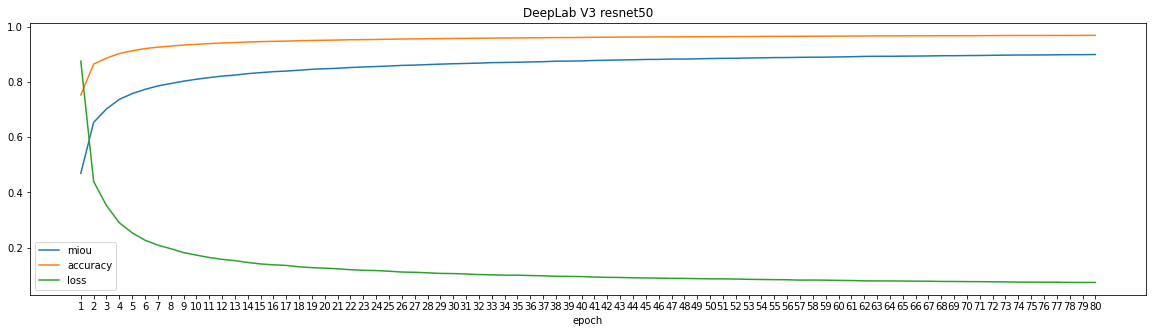

In [39]:
log_epoch = pd.read_csv('result/' + filename + '/train_log_epoch.csv', names = ['epoch', 'loss', 'accuracy', 'miou'])

plt.figure(figsize=(20, 5))
plt.plot(log_epoch['epoch'], log_epoch['miou'], label = 'miou')
plt.plot(log_epoch['epoch'], log_epoch['accuracy'], label = 'accuracy')
plt.plot(log_epoch['epoch'], log_epoch['loss'], label = 'loss')
plt.xticks([i for i in range(1, log_epoch.shape[0]+1)])
plt.title("DeepLab V3 resnet50")
plt.xlabel("epoch")
plt.ylabel("")
plt.legend()
plt.show()

### test

In [40]:
X = torch.tensor(test_x, dtype=torch.float32)
Y = torch.tensor(test_y, dtype=torch.long)

data = torch.utils.data.TensorDataset(X.permute(dims=(0, 3, 1, 2)), Y)

test_data = torch.utils.data.DataLoader(data, batch_size=1, shuffle=True)

In [45]:
# Load best model

save_path = os.getcwd() + '/result/' + filename + '/'
result = [file for file in sorted(os.listdir(save_path), reverse=True) if file == 'best_weights.pth.tar' ]

In [47]:
bestmodel = result[0]

In [48]:
checkpoint = torch.load(save_path + bestmodel) # 가장 최신 best_weights 파일 가져옴
model.load_state_dict(checkpoint['model_state_dict'], strict=True)
print('Loaded best model weights (epoch {}) from {}'.format(checkpoint['epoch'], save_path + bestmodel))

Loaded best model weights (epoch 80) from /home/ag/Capstone2/TEST/result/08_resnet_50/best_weights.pth.tar


In [49]:
batch_time = AverageMeter('Time', ':6.3f')
data_time = AverageMeter('Data', ':6.3f')
progress = ProgressMeter(
    len(test_data),
    [batch_time, data_time],
    prefix='Predict: ')

model.eval()

for batch, (x, y) in enumerate(tqdm(test_data, total=len(test_data))):

    x = x.to(device)
    y = y.to(device)

    # forward
    outputs = model(x)
    outputs = outputs['out']

    preds = torch.argmax(outputs, 1)

    # cross-entropy loss
    loss = criterion(outputs, y)

    # Statistics
    bs = x.size(0)
    loss = loss.item()
    loss_running.update(loss, bs)
    corrects = torch.sum((preds == y) & (y != 12))

    nvoid = int((y==12).sum())
    acc = corrects.double()/(bs*res-nvoid)
    acc_running.update(acc, bs)

    # Calculate IoU scores of current batch
    iou.evaluateBatch(preds, y)

miou = iou.outputScores()
scheduler.step(loss_running.avg)

print('loss : {:.4f} acc : {:.4f} miou : {:.4f}'.format(loss_running.avg, acc_running.avg, miou))

100%|██████████| 141/141 [00:15<00:00,  9.36it/s]

classes           IoU
---------------------
Pole          : 0.622
SignSymbol    : 0.840
Bicyclist     : 0.871
Pedestrian    : 0.797
Building      : 0.950
Fence         : 0.917
Pavement      : 0.934
Road          : 0.983
Car           : 0.947
Sky           : 0.937
Tree          : 0.916
---------------------
Mean IoU      : 0.883
---------------------
loss : 0.1769 acc : 0.9629 miou : 0.8829
